# Classifing hate speech tweets
## Using Multi-variate Bernoulli Naive Bayes and Multinominal Naive Bayes in combination with count vectorizer and TF-IDF vectorizer

### To Do's/ Ideas
- Remove 'user' string as it doesnt contain information and possibly negatively affects performance as Naive Bayes has problems with too many redundant attributes
- Modify Preprocessing (currently default count and TF-IDF vectroizer preprocessing used)
    - Implement Emoji transformation
    - Implement Morphological Normalization (e.g. Stemming)
    - Currently stop words are only removed in one scenario

In [182]:
import numpy as np
import pandas as pd
import sklearn.model_selection as ms
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [183]:
from string import punctuation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [184]:
from datasets import load_dataset

dataset = load_dataset("tweets_hate_speech_detection")

Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (C:\Users\Jonas\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)
100%|██████████| 1/1 [00:00<00:00, 143.34it/s]


In [185]:
df = pd.DataFrame.from_dict(dataset['train'])
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [186]:
# Currently not in use
def remove_punctioation(text:str) -> str:
    return "".join([i for i in text if i not in punctuation])

def tokenization(text:str) -> list:
    return nltk.word_tokenize(text)

def remove_stopwords(tokens) ->list:
    stopwords_list = stopwords.words("english")
    return [token for token in tokens if token not in stopwords_list]

porter_stemmer = PorterStemmer()

def stemming(text:list) -> list:
    return [porter_stemmer.stem(word) for word in text]

def preProcess(list):
    return list.apply(lambda x: stemming(remove_stopwords(tokenization(remove_punctioation(x.lower())))))

def validate(y_test,y_pred):
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_pred))

In [187]:
# Currently not in use
df["preprocessed"] = preProcess(df["tweet"])

In [188]:
df['no_user']= df['tweet'].str.replace("user","")

In [189]:
df.head()

,label,tweet,preprocessed,no_user
0,0,@user when a father is dysfunctional and is so...,"[user, father, dysfunct, selfish, drag, kid, d...",@ when a father is dysfunctional and is so sel...
1,0,@user @user thanks for #lyft credit i can't us...,"[user, user, thank, lyft, credit, cant, use, c...",@ @ thanks for #lyft credit i can't use cause ...
2,0,bihday your majesty,"[bihday, majesti]",bihday your majesty
3,0,#model i love u take with u all the time in ...,"[model, love, u, take, u, time, urð±, ðð...",#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,"[factsguid, societi, motiv]",factsguide: society now #motivation


# Model Building

In [190]:
# Definition des Label-Vektors
y = df['label']

## Using TF-IDF Vectorizer

In [191]:
# Definition der Feature-Matrix
tf = text.TfidfVectorizer(stop_words='english')

X_vec = tf.fit(df['tweet'])
X = X_vec.transform(df['tweet'])

print(X.shape)

(31962, 41104)


In [192]:
'''# No User string
# Definition der Feature-Matrix
tf = text.TfidfVectorizer(stop_words='english')

X_vec = tf.fit(df['no_user'])
X = X_vec.transform(df['no_user'])

print(X.shape)'''

"# No User string\n# Definition der Feature-Matrix\ntf = text.TfidfVectorizer(stop_words='english')\n\nX_vec = tf.fit(df['no_user'])\nX = X_vec.transform(df['no_user'])\n\nprint(X.shape)"

### Splitting Data into train and test data

In [193]:
# Splitting of data into training and test data
(X_train, X_test, y_train, y_test) = ms.train_test_split(X, y, test_size=0.2, random_state = 17, stratify=y)

In [194]:
# Testing Stratification
print('There is {} training data, of which {}% is hate speech '.format(y_train.count(), round(y_train.sum()/y_train.count()*100,2)))
print('There is {} test data, of which {}% is hate speech '.format(y_test.count(), round(y_test.sum()/y_test.count()*100,2)))

There is 25569 training data, of which 7.02% is hate speech 
There is 6393 test data, of which 7.01% is hate speech 


### Train Models
The method GridSearchCV is used for hyperparameter optimization. In the following cases the smoothing parameter alpha is optimized.

In [195]:
# Multi-variate Bernoulli Naive Bayes
bnb = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
bnb.fit(X_train, y_train);

# Multinominal Naive Bayes
mnb = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
mnb.fit(X_train, y_train);

### Evaluate Model Performance based on TF-IDF Vectorizer

In [196]:
print('Scores with the multi-variate Bernoulli Naive Bayes:')
validate(y_test, bnb.predict(X_test))

Scores with the multi-variate Bernoulli Naive Bayes:
Precision: 0.648
Recall: 0.551
Accuracy: 0.948
F1 Score: 0.596


In [197]:
print('Scores with the Multinominal Bernoulli Naive Bayes:')
validate(y_test, mnb.predict(X_test))

Scores with the Multinominal Bernoulli Naive Bayes:
Precision: 0.715
Recall: 0.542
Accuracy: 0.953
F1 Score: 0.617


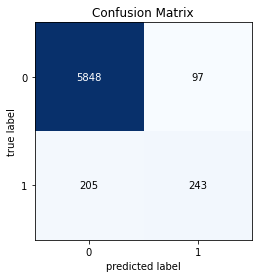

In [198]:
# Confusion-Matrix
cm = confusion_matrix(y_test, mnb.predict(X_test))

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()

# Using Count Vectorizer

In [199]:
'''# No user string
co = text.CountVectorizer(stop_words='english')

Xc_vec = co.fit(df['no_user'])
Xc = Xc_vec.transform(df['no_user'])

print(Xc.shape)'''

"# No user string\nco = text.CountVectorizer(stop_words='english')\n\nXc_vec = co.fit(df['no_user'])\nXc = Xc_vec.transform(df['no_user'])\n\nprint(Xc.shape)"

In [200]:
co = text.CountVectorizer(stop_words='english')

Xc_vec = co.fit(df['tweet'])
Xc = Xc_vec.transform(df['tweet'])

print(Xc.shape)

(31962, 41104)


### Split Data

In [201]:
# Splitting of data into training and test data
(Xc_train, Xc_test, yc_train, yc_test) = ms.train_test_split(Xc, y, test_size=.2, random_state = 17)

### Train Models

In [202]:
# Multi-variate Bernoulli Naive Bayes
bnbc = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
bnbc.fit(Xc_train, yc_train);


# Multinominal Naive Bayes
mnbc = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
mnbc.fit(Xc_train, yc_train);

### Evaluate Model Performance based on Count Vectorizer

In [203]:
print('Scores with the multi-variate Bernoulli Naive Bayes:')
validate(yc_test, bnbc.predict(Xc_test))

Scores with the multi-variate Bernoulli Naive Bayes:
Precision: 0.641
Recall: 0.568
Accuracy: 0.950
F1 Score: 0.602


In [204]:
print('Scores with the multi-variate Bernoulli Naive Bayes:')
validate(yc_test, mnbc.predict(Xc_test))

Scores with the multi-variate Bernoulli Naive Bayes:
Precision: 0.623
Recall: 0.526
Accuracy: 0.947
F1 Score: 0.570


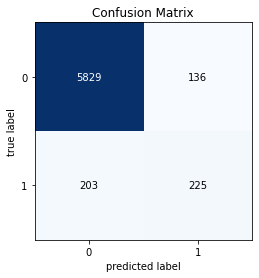

In [205]:
# Confusion-Matrix
cm = confusion_matrix(yc_test, mnbc.predict(Xc_test))

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()

# Analyze frequent words

In [206]:
'''# Get most frequent words including stop words
word_freq_df = pd.DataFrame(Xc.toarray(), columns=co.get_feature_names_out())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)
top_words_df.head(10)'''

MemoryError: Unable to allocate 9.79 GiB for an array with shape (31962, 41104) and data type int64

## Get words with biggest impact on each category

In [207]:
mnbc = nb.MultinomialNB()
mnbc.fit(Xc_train, yc_train);

In [208]:
# Get words with biggest impact on each category

mnbc.feature_log_prob_
mnbc.coef_

feature_names = co.get_feature_names_out()
for i, class_label in enumerate(['no_hate', 'hate']):
    top10 = np.argsort(mnbc.feature_log_prob_[i])[-10:]
    print("%s: %s" % (class_label,
          " ".join(feature_names[j] for j in top10)))

no_hate: thankful today life time just amp happy day love user
hate: people politics racist black like libtard white trump amp user


c:\Users\Jonas\miniconda3\envs\DataMining\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


# Upsample

In [209]:
# Train TFIDF BEFORE upsampling
tf = text.TfidfVectorizer(stop_words='english')

X_vec = tf.fit(df['tweet'])

In [210]:
# Prepare Split data
y = df['label']
X = df['tweet']

In [211]:
# Split data BEFORE upsampling
(X_train, X_test, y_train, y_test) = ms.train_test_split(X, y, test_size=0.2, random_state = 17, stratify=y)

df_train = pd.concat([y_train,X_train], axis=1)
df_test = pd.concat([y_test,X_test], axis = 1)
df_train.head()

,label,tweet
30405,0,when everyone's free when you're in exam mode ...
27807,0,#jacksonville rooster simulation: i want to ...
8660,0,@user just run 10kms for @user @user #loveis...
19185,0,@user got the prototype for our new usb today!...
10355,0,have a &amp; #healthy #fathersday. #runnerda...


In [212]:
data_minority = df_train[df_train.label == 1]
data_majority = df_train[df_train.label == 0]

print("length majority", len(data_majority))
print("length minority", len(data_minority))

length majority 23775
length minority 1794


In [213]:
from sklearn.utils import resample
data_minority = resample(data_minority, replace = True, n_samples=23775, random_state=55)

In [214]:
df_train_up = pd.concat([data_majority, data_minority])
df_train_up.label.value_counts()

0    23775
1    23775
Name: label, dtype: int64

In [215]:
# create tfidf embeddings

X_train = X_vec.transform(df_train_up['tweet'])
X_test = X_vec.transform(df_test['tweet'])
y_train = df_train_up['label']
y_test = df_test['label']

print(X_train.shape) 

(47550, 41104)


In [219]:
# Testing Stratification
print('There is {} training data, of which {}% is hate speech '.format(df_train_up['label'].count(), round(df_train_up['label'].sum()/df_train_up['label'].count()*100,2)))
print('There is {} test data, of which {}% is hate speech '.format(df_test['label'].count(), round(df_test['label'].sum()/df_test['label'].count()*100,2)))

There is 47550 training data, of which 50.0% is hate speech 
There is 6393 test data, of which 7.01% is hate speech 


In [217]:
# Multi-variate Bernoulli Naive Bayes
bnb = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
bnb.fit(X_train, y_train);

# Multinominal Naive Bayes
mnb = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
mnb.fit(X_train, y_train);



In [218]:
print('Scores with the multi-variate Bernoulli Naive Bayes:')
validate(y_test, bnb.predict(X_test))
print('Scores with the Multinominal Bernoulli Naive Bayes:')
validate(y_test, mnb.predict(X_test))

Scores with the multi-variate Bernoulli Naive Bayes:
Precision: 0.589
Recall: 0.690
Accuracy: 0.944
F1 Score: 0.635
Scores with the Multinominal Bernoulli Naive Bayes:
Precision: 0.550
Recall: 0.694
Accuracy: 0.939
F1 Score: 0.614


In [ ]:
# Confusion-Matrix
cm = confusion_matrix(y_test, mnb.predict(X_test))

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()